In [161]:
import numpy as np
import pandas as pd
import nltk
import spacy
import seaborn as sns
import gensim
import texthero as hero
import plotly.express as px
import pyLDAvis
import pyLDAvis.gensim

import gensim.corpora as corpora
from pprint import pprint

from nltk import word_tokenize
from nltk.util import ngrams
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_squared_error,
                             explained_variance_score,
                             max_error,
                             mean_absolute_error,
                             median_absolute_error,
                             r2_score)
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
import re
import os
import pickle
nltk.download('stopwords')

import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

from texthero import preprocessing as pp
from sklearn.cluster import MiniBatchKMeans as mb


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/milanmcgraw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/milanmcgraw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [113]:
df = pd.read_csv('/Users/milanmcgraw/MSAI_AI/Data Science/Invisible-Institute-Chicago-Reporter-Collaboration-Public/The Spectacular Sailors/Checkpoint_5/narrative_crews.csv')

In [114]:
df

,id,text_content,officer_id,cohort,community_id,crew_id
0,58067,It is alleged that three unknown white male\no...,21441,3,0,0
1,83721,The reporting party alleged that the accused\n...,28429,3,0,0
2,77144,police report regarding an unknown subject\nor...,28429,3,0,0
3,73538,The reporting party alleged the accused\nliste...,28429,3,0,0
4,73893,The complainant alleged that the accused\noffi...,27564,2,455,0
...,...,...,...,...,...,...
33113,72910,The complainant alleged that the accused\noffi...,4953,3,0,0
33114,67320,It 1s alleged that the accused officer ordered...,4953,3,0,0
33115,90776,It is reported that the accused has not\nsettl...,8992,2,346,0
33116,72608,THE REPORTING PARTY STATES THAT\nTHE ACCUSED O...,8992,2,346,0


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33118 entries, 0 to 33117
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            33118 non-null  int64 
 1   text_content  33118 non-null  object
 2   officer_id    33118 non-null  int64 
 3   cohort        33118 non-null  int64 
 4   community_id  33118 non-null  int64 
 5   crew_id       33118 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 1.5+ MB


In [116]:
def cleaner(df):
    print('Cleaning ====')
    charge_pipeline1 = [pp.fillna
                        , pp.remove_digits
                        , pp.lowercase
                        , pp.remove_punctuation
                        , pp.remove_stopwords
                        , pp.remove_diacritics
                        , pp.remove_whitespace
                        ]
    print('Done Cleaning ====')
    df['text_content'] = hero.clean(df['text_content'], pipeline=charge_pipeline1)
    print('Sample')
    print(df.head(2))
    return df

In [117]:
df_clean = cleaner(df)

Cleaning ====
Done Cleaning ====
Sample
      id                                       text_content  officer_id  \
0  58067  alleged three unknown white male officers stat...       21441   
1  83721  reporting party alleged accused stopped demand...       28429   

   cohort  community_id  crew_id  
0       3             0        0  
1       3             0        0  


In [118]:
df_clean.head()

,id,text_content,officer_id,cohort,community_id,crew_id
0,58067,alleged three unknown white male officers stat...,21441,3,0,0
1,83721,reporting party alleged accused stopped demand...,28429,3,0,0
2,77144,police report regarding unknown subject subjec...,28429,3,0,0
3,73538,reporting party alleged accused listed son bla...,28429,3,0,0
4,73893,complainant alleged accused officer assigned r...,27564,2,455,0


In [150]:
narrative_content = ''
for i in range(df_clean.shape[0]):
    if i == 0:
        narrative_content = df_clean['text_content'][i]
    else:
        narrative_content += df_clean['text_content'][i]


In [151]:
tokens = word_tokenize(narrative_content)
print(len(tokens))

804898


In [146]:
# Filtering word list
spacy.load('en_core_web_sm')
quotes = spacy.lang.punctuation.LIST_QUOTES
punct = spacy.lang.punctuation.LIST_PUNCT
stop_words = stopwords.words("english")
num=['0','1','2','3','4','5','6','7','8','9','&','-','',"'","--"]
trunc_elements = num + stop_words + punct + quotes
trunc = num + punct + quotes

filtered_tokens = []
for i in tokens:
    if i not in trunc:
        filtered_tokens.append(i)

In [147]:
print(filtered_tokens[:50])

['alleged', 'three', 'unknown', 'white', 'male', 'officers', 'stated', 'complainant', 'traffic', 'stop', 'weedreporting', 'party', 'alleged', 'accused', 'stopped', 'demanded', 'see', 'identification', 'apparent', 'reason', 'alleged', 'accused', 'officer', 'ordered', 'exit', 'vehicle', 'failed', 'explain', 'stopping', 'alleged', 'accused', 'officer', 'threatened', 'arrest', 'call', 'place', 'employmentpolice', 'report', 'regarding', 'unknown', 'subject', 'subjects', 'breaking', 'personal', 'vehicle', 'stealing', 'personal', 'items', 'reporting', 'party']


In [148]:
unique_words = []
for word in filtered_tokens:
    if word not in unique_words:
        unique_words.append(word)
print(len(unique_words))

27626


In [149]:
from gensim.corpora import Dictionary
id2word = Dictionary([filtered_tokens])
corpus = [id2word.doc2bow([text]) for text in filtered_tokens]

In [125]:
for c in corpus:
    print(c[0])
    if c[0][1] > 1:
        print(c)
    break
print(corpus[:1])

(1409, 1)
[[(1409, 1)]]


In [126]:
word_freq = nltk.FreqDist(filtered_tokens)

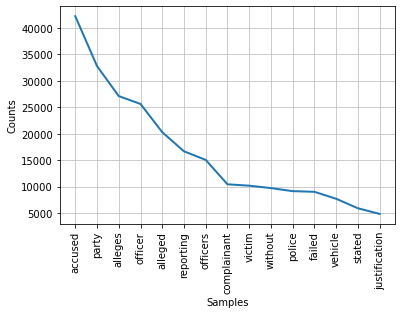

In [127]:
word_freq.plot(15)

In [128]:
word_freq.most_common(50)

[('accused', 42231),
 ('party', 32792),
 ('alleges', 27114),
 ('officer', 25631),
 ('alleged', 20280),
 ('reporting', 16662),
 ('officers', 15037),
 ('complainant', 10419),
 ('victim', 10157),
 ('without', 9700),
 ('police', 9123),
 ('failed', 8999),
 ('vehicle', 7679),
 ('stated', 5880),
 ('justification', 4813),
 ('report', 4768),
 ('male', 4403),
 ('arrested', 4302),
 ('states', 4259),
 ('unknown', 4106),
 ('refused', 4041),
 ('searched', 3908),
 ('called', 3906),
 ('arrest', 3750),
 ('told', 3345),
 ('stopped', 3019),
 ('provide', 2986),
 ('rude', 2865),
 ('traffic', 2858),
 ('residence', 2656),
 ('incident', 2629),
 ('hours', 2591),
 ('white', 2529),
 ('citation', 2508),
 ('also', 2426),
 ('issued', 2386),
 ('regarding', 2379),
 ('district', 2367),
 ('falsely', 2342),
 ('warrant', 2330),
 ('threatened', 2282),
 ('one', 2257),
 ('unprofessional', 2218),
 ('time', 2204),
 ('search', 2126),
 ('car', 2082),
 ('two', 2073),
 ('chicago', 2048),
 ('witness', 2040),
 ('uniformed', 1969)]

In [129]:
lda_model = LdaModel(corpus=corpus,
                   id2word=id2word,
                   num_topics=10, 
                   random_state=0,
                   chunksize=100,
                   alpha='auto',
                   per_word_topics=True)

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.466*"alleged" + 0.348*"officers" + 0.121*"report" + 0.000*"fast" + '
  '0.000*"chokedreporting" + 0.000*"residencts" + 0.000*"humiliated" + '
  '0.000*"cottage" + 0.000*"grove" + 0.000*"resided"'),
 (1,
  '0.389*"complainant" + 0.202*"states" + 0.165*"male" + 0.086*"hours" + '
  '0.042*"reason" + 0.000*"fast" + 0.000*"chokedreporting" + '
  '0.000*"residencts" + 0.000*"resided" + 0.000*"humiliated"'),
 (2,
  '0.528*"vehicle" + 0.173*"white" + 0.072*"left" + 0.031*"however" + '
  '0.000*"porccomplainant" + 0.000*"porchcomplainant" + 0.000*"pops" + '
  '0.000*"pop" + 0.000*"porch" + 0.000*"porchreported"'),
 (3,
  '0.474*"officer" + 0.163*"without" + 0.160*"police" + 0.052*"rude" + '
  '0.046*"regarding" + 0.026*"subject" + 0.024*"get" + 0.009*"three" + '
  '0.000*"fast" + 0.000*"chokedreporting"'),
 (4,
  '0.312*"arrest" + 0.248*"unprofessional" + 0.068*"apparent" + 0.064*"place" '
  '+ 0.000*"poorly" + 0.000*"pop" + 0.000*"popped" + 0.000*"pops" + '
  '0.000*"porccomplainant"

In [134]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=filtered_tokens, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\\nCoherence Score: ', coherence_lda)

\nCoherence Score:  nan


In [142]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.430821 -0.170729       1        1  63.020248
3     -0.082945  0.386338       2        1   7.390367
7     -0.000269  0.067698       3        1   6.062456
0      0.012221  0.041990       4        1   5.581013
5     -0.000835  0.068755       5        1   5.516908
9      0.062362 -0.035274       6        1   4.199708
1      0.099422 -0.076349       7        1   3.136834
6      0.108361 -0.085245       8        1   2.303907
2      0.119354 -0.097886       9        1   1.661695
4      0.113151 -0.099297      10        1   1.126861, topic_info=                     Term          Freq         Total Category  logprob  \
17612               party  34304.000000  34304.000000  Default   30.000   
1419              alleges  30158.000000  30158.000000  Default   29.000   
16861             officer  28191.000000  28191.000000  Default   28.000   
1409              alleged  20921.000000  20921.000000  Default   27.000   
20221           reporting  17755.000000  17755.000000  Default   26.000   
...                   ...           ...           ...      ...      ...   
9223   firearmcomplainant      0.101066      1.022204  Topic10  -11.404   
9224           firearmcpd      0.101066      1.022078  Topic10  -11.404   
9203        fingerprinted      0.101066      1.022078  Topic10  -11.404   
9201          fingernails      0.101066      1.026107  Topic10  -11.404   
9226          firearmhire      0.101066      1.022078  Topic10  -11.404   

       loglift  
17612  30.0000  
1419   29.0000  
16861  28.0000  
1409   27.0000  
20221  26.0000  
...        ...  
9223    2.1718  
9224    2.1719  
9203    2.1719  
9201    2.1680  
9226    2.1719  

[791 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
746        1  0.999744  accident
836        1  0.999975   accused
1409       4  0.999951   alleged
1419       3  0.999964   alleges
1507       1  0.999559      also
...      ...       ...       ...
26705      1  0.999816   warrant
26807      8  0.998989       way
26989      9  0.999667     white
27177      2  0.999866   without
27191      1  0.999573   witness

[85 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 4, 8, 1, 6, 10, 2, 7, 3, 5])

The further the bubbles are away from each other, the more different they are. For example, it is difficult to tell the difference between topics 9 and 10. They seem to be both about unprofessional arrests, but it is much easier to tell the difference between topics 5 and 6. We can tell that topic 5 is about a bad traffic stop.


The 1st bubble seems to be all text
The 2nd bubble seems to be getting stopped by officer who were very rude and without cause
The 3rd bubble seems to be getting stopped without justification and they feel as if they are the victim
The 4th bubble seems to be about alleged officers are potentially accused them of a crime
The 5th bubble seems to be about a traffic stop coming from a party and stoped because they were black
The 6th bubble seems to be about a parent making complaints that officers threatened their son, stoped one or two times.
The 7th bubble seems to be about a complaint that they were stopped for no reason at strange hours
The 8th bubble seems to be about 
The 9th bubble seems to be about while sitting in their vehicle however I was.....
The 10th bubble seems to be about unprofessional and clearly apparent that they were coming to my place to arrest me 


In [156]:
#Generate bigrams and trigrams
def generate_ngrams(text, n):
    ngrams = zip(*[text[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

bigram_freq = {}
for i in range(len(filtered_tokens)-1):
    bigram = (filtered_tokens[i],  filtered_tokens[i+1])
    if bigram not in bigram_freq:
        bigram_freq[bigram] = 0
    bigram_freq[bigram] += 1
        
trigram_freq = {}
for i in range(len(filtered_tokens)-2):
    trigram = (filtered_tokens[i],  filtered_tokens[i+1], filtered_tokens[i+2])
    if trigram not in trigram_freq:
        trigram_freq[trigram] = 0
    trigram_freq[trigram] += 1
# bigrams = generate_ngrams(list(filtered_tokens), 2)
# trigrams = generate_ngrams(list(filtered_tokens), 3)
print("Total bigrams: ",len(filtered_tokens))
print("Total bigrams: ",len(bigram_freq))
print("Total trigrams: ",len(trigram_freq))

Total bigrams:  804891
Total bigrams:  170475
Total trigrams:  295604


In [152]:
# bigram_freq = defaultdict(int)
# for bigram in bigrams:
#     for x in df_clean['text_content']:
#         bigram_freq[bigram]+=1
# print(len(bigram_freq))

# save_bigram_freq = open("bigram_freq.pickle","wb")
# pickle.dump(bigram_freq, save_bigram_freq)
# save_bigram_freq.close()

KeyboardInterrupt: 

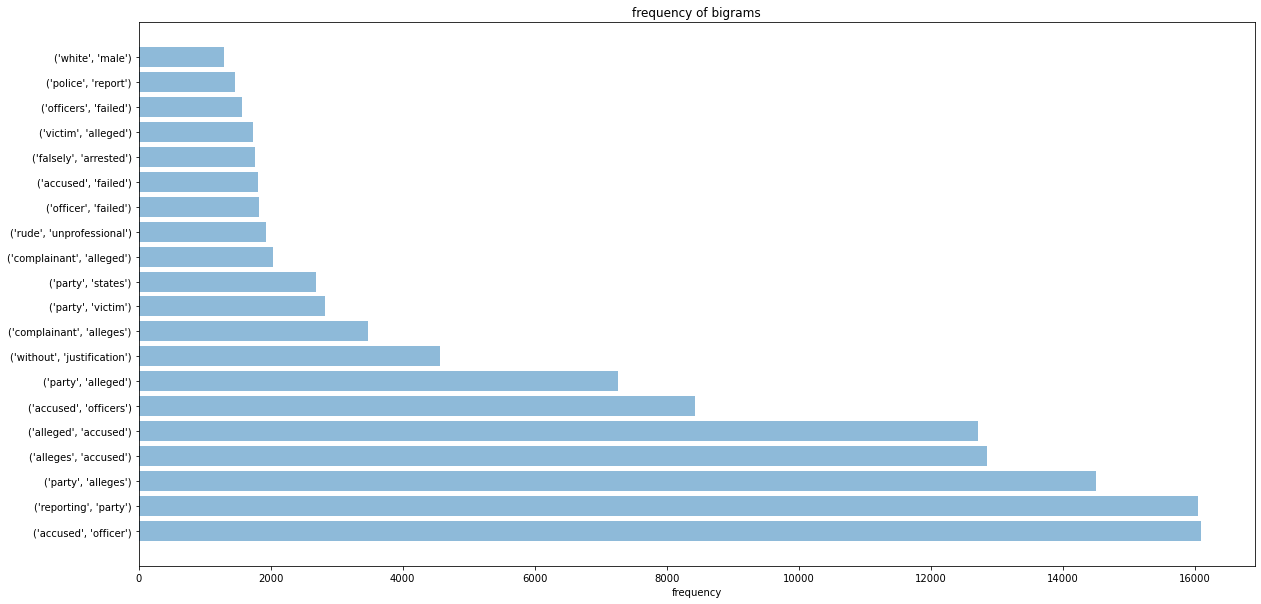

In [160]:
#Plot bigram frequencies
sorted_bigram_freq = sorted(bigram_freq.items(), key=lambda v: v[1], reverse = True)
phrases = []
freq = []
for x in range(len(sorted_bigram_freq)):
    phrases.append(sorted_bigram_freq[x][0])
    freq.append(sorted_bigram_freq[x][1])
phrases = phrases[:20]
freq = freq[:20]
y_pos = np.arange(len(phrases))
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.barh(y_pos, freq, align='center', alpha=0.5)
plt.yticks(y_pos, phrases)
plt.xlabel('frequency')
plt.title('frequency of bigrams')
plt.show()

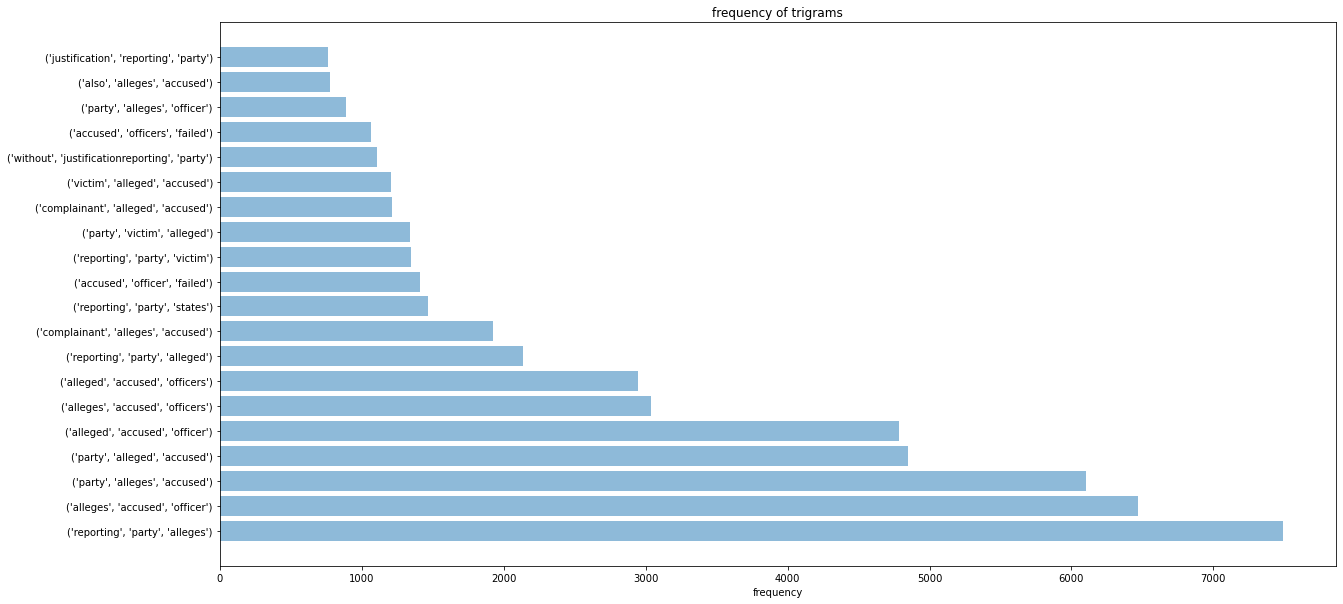

In [158]:
#Plot trigram frequencies
sorted_trigram_freq = sorted(trigram_freq.items(), key=lambda v: v[1], reverse = True)
phrases = []
freq = []
for x in range(len(sorted_trigram_freq)):
    phrases.append(sorted_trigram_freq[x][0])
    freq.append(sorted_trigram_freq[x][1])
phrases = phrases[20:40]
freq = freq[20:40]
y_pos = np.arange(len(phrases))
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.barh(y_pos, freq, align='center', alpha=0.5)
plt.yticks(y_pos, phrases)
plt.xlabel('frequency')
plt.title('frequency of trigrams')
plt.show()

In [141]:

text = filtered_tokens
token=nltk.word_tokenize(text)
bigrams=ngrams(token,2)

TypeError: expected string or bytes-like object